In [1]:
# Install libraries for data_loader
!pip install pandas
!pip install sklearn
!pip install torchvision
!pip install tqdm
!pip install torchmetrics

In [2]:
# Import DataLoader and corresponding libraries
import pandas
import torchvision.transforms as TT
from torch.utils.data import DataLoader, Dataset, sampler
from sklearn.model_selection import StratifiedKFold
from torchvision import utils
from PIL import Image

In [3]:
# Import libraries for tensors
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [4]:
# For fbeta-score
from torchmetrics.functional import fbeta_score

In [5]:
# For model construction
from collections import OrderedDict

In [6]:
# Import tqdm for progress bar construction
import tqdm

In [7]:
# from google.colab import drive
# drive.mount('/content/gdrive')

# Datatypes and Devices (from Assignment 2)
dtype = torch.float
ltype = torch.long

if torch.cuda.is_available():
    device = torch.device('cuda:0')
else:
    device = torch.device('cpu')

print('using device:', device)

using device: cuda:0


In [8]:
# Hyper-parameters for K-Fold Cross Validation
N = 8
seed = 42

torch.manual_seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
random.seed(seed)

# Directories for Data
FF1010_Path = './data/'
AudioImage_Path = './image/'

In [9]:
# Call StratifiedKFold object
skf = StratifiedKFold(
    n_splits=N, shuffle=True, random_state=seed
)

In [10]:
# Modify dataframe for K-Fold Cross Validation (birdclef2021)
birdclef_csv = pandas.read_csv(AudioImage_Path + 'metadata.csv')
birdclef_csv.loc[birdclef_csv['label_id'] >= 0,'filepath'] = \
    AudioImage_Path + birdclef_csv.query('label_id >= 0')['primary_label'] + '/' + \
    birdclef_csv.query('label_id >= 0')['filename'] + '.npy'

birdclef_csv = birdclef_csv.dropna()
birdclef_csv = birdclef_csv.reset_index(drop=True)

# Add 'fold' attribute for dataset classification
birdclef_dataframe = birdclef_csv.copy()
for n, (_, nth_groups) in enumerate(
    skf.split(birdclef_dataframe, birdclef_dataframe['label_id'])):
    birdclef_dataframe.loc[nth_groups, 'fold'] = int(n)

In [11]:
# Class for Birdclef dataset
class birdclef(Dataset):
    def __init__(self, dataframe, process='train', labels='label_id'):
        self.dataframe = dataframe
        self.filepaths = dataframe['filepath'].values
        self.labels = dataframe[labels].values
        self.process = process
        self.batch_threshold = 64
        
        # Transforms for each train and validation
        self.train_transform = TT.Compose([
            TT.Resize([128, 281]),
            TT.RandomHorizontalFlip(p=0.5),
            TT.RandomVerticalFlip(p=0.5),
            TT.ToTensor(),
            TT.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
            ),
        ])
        self.val_transform = TT.Compose([
            TT.Resize([128, 281]),
            TT.ToTensor(),
            TT.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
            ),
        ])
    
    def __getitem__(self, idx):
        source = np.load(self.filepaths[idx])
        
        # Rearrange numpy arrays
        source = source.transpose(1, 2, 0)
        
        # Add RGB dimension
        source = np.stack((np.squeeze(source), ) * 3, -1)
        if len(source.shape) == 3:
            source = np.expand_dims(source, axis=2)
        source = source.transpose(2, 0, 1, 3)
        N, H, W, C = source.shape
        label_rp = N
        
        # Apply transform
        if self.process == 'train':
            source = torch.stack([self.train_transform(Image.fromarray(x)) for x in source])
        elif self.process == 'valid':
            source = torch.stack([self.val_transform(Image.fromarray(x)) for x in source])
        
        # Avoid CUDA OOM
        if N > self.batch_threshold:
            unit = (N - self.batch_threshold) // 2
            label_rp = self.batch_threshold
            if N % 2 == 0:
                source = source[unit : -unit]
            else:
                source = source[unit : -(unit + 1)]
        
        return source, torch.tensor(self.labels[idx], dtype=ltype).repeat(label_rp)
    
    def __len__(self):
        return len(self.dataframe)

This function evaluates model.

In [12]:
def evaluate_model(loader, model, beta=1.0):
    print("Checking accuracy score on validation set.")
    # TODO: extend this so that we can print that we evaluate test set.
    num_correct = 0
    num_samples = 0
    log_sum = 0
    fbeta_sum = 0
    model.eval()
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device, dtype=torch.float)
            y = y.to(device=device, dtype=torch.long)
            y = torch.squeeze(y, 0)
            scores = model(torch.squeeze(x, 0))
            # scores means classfication class for each class. It should be the tensor with size of (Input size, Number of classes)

            # Checks naive accuracy.
            _, preds = scores.max(1)
            num_correct += (preds == y).sum()
            num_samples += preds.size(0)

            # Checks Log Loss.
            log_loss = F.cross_entropy(scores, y)
            log_sum += log_loss.sum() * preds.size(0)

            # Checks Fbeta-score.
            fbeta = fbeta_score(preds, y, beta=beta)
            fbeta_sum += fbeta * preds.size(0)
            
            # Erase memory caches
            del x, y, scores, log_loss
        
        acc = float(num_correct) / num_samples
        log_score = log_sum / num_samples
        f_score = fbeta_sum / num_samples
        print('\nAccuracy: %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))
        print('Log Loss score:\t%.2f' % (log_score))
        print('Fbeta-score (beta=%d): \t%.2f' % (beta , f_score))
    return acc, log_score, f_score

Let's train with model 2.

In [13]:
import os

# Print period for accuracy.
print_period = 10000

# Hyper-parameters for training 
birdclef_batch = 1
birdclef_epoch = 25

# Learning Rate
learning_rate_2 = 5e-4
eta_min = 5e-6
momentum = 0.5

# L2 Regularization Hyperparamter
weight_decay_2 = 0.001

# Beta constant for Fbeta-score.
# If you want to give more weight to precision, use value smaller than 1.0.
# If you want to give more weight to recall, use value larger than 1.0.
beta = 1.0

# Prototype of model 2.
# ResNet50 outputs (Batchsize, 1000) tensor as output, so we reduce them to 397.
class Model2(nn.Module):
    def __init__(self, num_classes=397):
        super().__init__()
        self.resnet50 = torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', pretrained=True).to(device)
        self.relu = nn.ReLU().to(device)
        self.linear = nn.Linear(1000, num_classes, bias=True).to(device)
    
    def forward (self, x):
        x = self.resnet50(x)
        x = self.relu(x)
        x = self.linear(x)
        return x

cur_model = Model2()
print(cur_model)

def checkpoint(model, optimizer, scheduler, train_losses, val_losses, log_scores, fbeta_scores, epoch):
    torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'train_losses': train_losses,
            'val_losses': val_losses,
            'log_scores': log_scores,
            'fbeta_scores': fbeta_scores,
            }, './bird_species_classifier.pt')

def train_model(model, train_loader, val_loader, optimizer, scheduler, beta=beta, epoch=birdclef_epoch, ckpt_enable=True):
    val_losses = []
    train_losses = []
    log_scores = []
    fbeta_scores = []
    
    loss = 0
    log_score = 0
    saved_epoch = -1
    
    # Load checkpoint
    if ckpt_enable and os.path.exists('./bird_species_classifier.pt'):
        ckpt = torch.load('./bird_species_classifier.pt', map_location=device)
        model.load_state_dict(ckpt['model_state_dict'])
        optimizer.load_state_dict(ckpt['optimizer_state_dict'])
        scheduler.load_state_dict(ckpt['scheduler_state_dict'])
        train_losses = ckpt['train_losses']
        val_losses = ckpt['val_losses']
        log_scores = ckpt['log_scores']
        fbeta_scores = ckpt['fbeta_scores']
        saved_epoch = ckpt['epoch']
    
    for e in range(epoch):
        if e <= saved_epoch:
            continue
            
        epoch_losses = []
        print(f"Training model 2, epoch {e+1}")
        for index, (source, label) in enumerate(tqdm.tqdm(train_loader)):          
            x = source.to(device=device, dtype=torch.float)  # move to device, e.g. GPU
            y = label.to(device=device, dtype=torch.long)
            y = torch.squeeze(y, 0)

            scores = model(torch.squeeze(x, 0))
            loss = F.cross_entropy(scores, y) # Log loss for our project.

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_losses.append(loss.item())

            # every print_period, print loss.
            if index % print_period == 0:
                print('Iteration %d, loss = %.4f' % (index, loss.item()))
                
            # Erase memory caches
            del source, label, x, y, scores, loss
            
        # Cosine LR Annealing Scheduler
        scheduler.step()
        
        # Append the score to lists
        acc, log_score, fbeta_score = evaluate_model(val_loader, model, beta=beta)
        val_losses.append(acc)
        train_losses.append(torch.tensor(sum(epoch_losses) / len(epoch_losses), dtype=dtype))
        log_scores.append(log_score)
        fbeta_scores.append(fbeta_score)
        
        # every epoch, save the model
        checkpoint(model, optimizer, scheduler, train_losses, val_losses, log_scores, fbeta_scores, e)

    return model, val_losses, train_losses, log_scores, fbeta_scores

Using cache found in C:\Users\youngrae/.cache\torch\hub\pytorch_vision_v0.10.0


Model2(
  (resnet50): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          

In [14]:
# Train loop for bird specificator
def bird_train(model, train_dataframe, val_dataframe, test_dataframe):  
    train_data = birdclef(train_dataframe, process='train', labels='label_id')
    val_data = birdclef(val_dataframe, process='valid', labels='label_id')
    test_data = birdclef(test_dataframe, process='valid', labels='label_id')
    
    # Construct data loader for train and validation
    train_loader = DataLoader(train_data, batch_size=birdclef_batch,
                             sampler=sampler.SubsetRandomSampler(range(len(train_dataframe))), 
                             drop_last=True)
    val_loader = DataLoader(val_data, batch_size=birdclef_batch,
                             sampler=sampler.SubsetRandomSampler(range(len(val_dataframe))),
                             drop_last=False)
    test_loader = DataLoader(test_data, batch_size=birdclef_batch,
                              sampler=sampler.SubsetRandomSampler(range(len(test_dataframe))),
                              drop_last=False)
    
    optimizer = optim.SGD(model.parameters(), lr=learning_rate_2, weight_decay=weight_decay_2, momentum=momentum)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=birdclef_epoch, eta_min=eta_min)
    trained_model, val_losses, train_losses, log_scores, fbeta_scores = train_model(
        model, train_loader, val_loader, optimizer, scheduler, beta=beta)
    test_acc, test_log_score, test_fbeta_score = evaluate_model(test_loader, trained_model, beta=beta)
    
    return val_losses, train_losses, log_scores, fbeta_scores, [test_acc, test_log_score, test_fbeta_score]

In [15]:
# Train, Validate and Test for nocall detector
def bird(model, dataframe, val_index, test_index):
    
    # Check that validation fold is not same as test fold
    assert val_index != test_index, \
        'Validation and test should be done on different fold.'
    print('Test set : %d, Validation set : %d' % (test_index, val_index))
    
    train_dataframe = dataframe.query(
        'fold != ' + str(val_index) + ' and fold != ' + str(test_index) 
    ).reset_index(drop=True)
    val_dataframe = dataframe.query(
        'fold == ' + str(val_index) 
    ).reset_index(drop=False)
    test_dataframe = dataframe.query(
        'fold == ' + str(test_index) 
    ).reset_index(drop=False)
    
    val_losses, train_losses, log_scores, fbeta_scores, test_scores = bird_train(
        model, train_dataframe, val_dataframe, test_dataframe)

    return val_losses, train_losses, log_scores, fbeta_scores, test_scores

In [16]:
val_losses, train_losses, log_scores, fbeta_scores, test_scores = \
    bird(cur_model, birdclef_dataframe, 1, 0)
del cur_model

# For K-fold cross validation
# for i in range(2, 8):
#     cur_model = Model2()
#     cv_losses, ctr_losses, cl_scores, cf_scores, cte_scores = nocall(cur_model, birdclef_dataframe, i, 0)
#     val_losses = torch.mean(torch.stack((torch.tensor(val_losses), torch.tensor(cv_losses))), dim=0)
#     train_losses = torch.mean(torch.stack((torch.tensor(train_losses), torch.tensor(ctr_losses))), dim=0)
#     log_scores = torch.mean(torch.stack((torch.tensor(log_scores), torch.tensor(cl_scores))), dim=0)
#     fbeta_scores = torch.mean(torch.stack((torch.tensor(fbeta_scores), torch.tensor(cf_scores))), dim=0)
#     for j in range(len(test_scores)):
#         test_scores[j] = torch.mean(torch.stack((torch.tensor(test_scores[j]), torch.tensor(cte_scores[j]))), dim=0)

Test set : 0, Validation set : 1
Training model 2, epoch 1


  0%|                                                                             | 3/47154 [00:03<10:36:20,  1.23it/s]

Iteration 0, loss = 6.2915


 21%|███████████████▋                                                          | 10003/47154 [13:03<1:04:52,  9.54it/s]

Iteration 10000, loss = 6.0991


 42%|████████████████████████████████▏                                           | 20005/47154 [25:57<23:47, 19.02it/s]

Iteration 20000, loss = 5.1301


 64%|████████████████████████████████████████████████▎                           | 30004/47154 [38:46<19:21, 14.76it/s]

Iteration 30000, loss = 6.2845


 85%|████████████████████████████████████████████████████████████████▍           | 40002/47154 [51:40<08:24, 14.19it/s]

Iteration 40000, loss = 5.6972


100%|██████████████████████████████████████████████████████████████████████████| 47154/47154 [1:00:52<00:00, 12.91it/s]


Checking accuracy score on validation set.

Accuracy: 11340 / 83918 correct (13.51)
Log Loss score:	5.41
Fbeta-score (beta=1): 	0.14
Training model 2, epoch 2


  0%|                                                                                | 2/47154 [00:00<53:02, 14.82it/s]

Iteration 0, loss = 7.5624


 21%|████████████████▏                                                           | 10005/47154 [12:38<36:53, 16.78it/s]

Iteration 10000, loss = 3.4077


 42%|████████████████████████████████▏                                           | 20002/47154 [25:21<47:16,  9.57it/s]

Iteration 20000, loss = 5.1358


 64%|████████████████████████████████████████████████▎                           | 30002/47154 [37:55<21:51, 13.07it/s]

Iteration 30000, loss = 2.6306


 85%|████████████████████████████████████████████████████████████████▍           | 40004/47154 [50:27<08:28, 14.06it/s]

Iteration 40000, loss = 5.2737


100%|████████████████████████████████████████████████████████████████████████████| 47154/47154 [59:30<00:00, 13.21it/s]


Checking accuracy score on validation set.

Accuracy: 30840 / 83918 correct (36.75)
Log Loss score:	3.60
Fbeta-score (beta=1): 	0.37
Training model 2, epoch 3


  0%|                                                                              | 1/47154 [00:00<2:34:01,  5.10it/s]

Iteration 0, loss = 2.3121


 21%|████████████████                                                            | 10001/47154 [12:31<41:31, 14.91it/s]

Iteration 10000, loss = 1.5822


 42%|████████████████████████████████▏                                           | 20001/47154 [25:16<37:06, 12.20it/s]

Iteration 20000, loss = 3.6308


 64%|████████████████████████████████████████████████▎                           | 30003/47154 [37:53<19:02, 15.01it/s]

Iteration 30000, loss = 3.1701


 85%|████████████████████████████████████████████████████████████████▍           | 40000/47154 [50:41<12:07,  9.83it/s]

Iteration 40000, loss = 2.1262


100%|████████████████████████████████████████████████████████████████████████████| 47154/47154 [59:35<00:00, 13.19it/s]


Checking accuracy score on validation set.

Accuracy: 38865 / 83918 correct (46.31)
Log Loss score:	3.09
Fbeta-score (beta=1): 	0.46
Training model 2, epoch 4


  0%|                                                                              | 1/47154 [00:00<1:23:17,  9.43it/s]

Iteration 0, loss = 2.3284


 21%|████████████████                                                            | 10002/47154 [12:39<45:00, 13.76it/s]

Iteration 10000, loss = 2.9919


 42%|████████████████████████████████▏                                           | 20002/47154 [25:14<26:20, 17.18it/s]

Iteration 20000, loss = 3.2285


 64%|████████████████████████████████████████████████▎                           | 30001/47154 [37:52<19:33, 14.62it/s]

Iteration 30000, loss = 2.6029


 85%|████████████████████████████████████████████████████████████████▍           | 40003/47154 [50:35<09:22, 12.71it/s]

Iteration 40000, loss = 0.9154


100%|████████████████████████████████████████████████████████████████████████████| 47154/47154 [59:36<00:00, 13.18it/s]


Checking accuracy score on validation set.

Accuracy: 44673 / 83918 correct (53.24)
Log Loss score:	2.71
Fbeta-score (beta=1): 	0.53
Training model 2, epoch 5


  0%|                                                                              | 1/47154 [00:00<1:32:43,  8.48it/s]

Iteration 0, loss = 4.6163


 21%|████████████████                                                            | 10001/47154 [12:34<43:11, 14.34it/s]

Iteration 10000, loss = 0.5057


 42%|████████████████████████████████▏                                           | 20002/47154 [25:05<25:04, 18.05it/s]

Iteration 20000, loss = 4.1457


 64%|████████████████████████████████████████████████▎                           | 30003/47154 [37:44<24:41, 11.57it/s]

Iteration 30000, loss = 2.2797


 85%|████████████████████████████████████████████████████████████████▍           | 40002/47154 [50:27<06:46, 17.59it/s]

Iteration 40000, loss = 0.0903


100%|████████████████████████████████████████████████████████████████████████████| 47154/47154 [59:29<00:00, 13.21it/s]


Checking accuracy score on validation set.

Accuracy: 47382 / 83918 correct (56.46)
Log Loss score:	2.57
Fbeta-score (beta=1): 	0.56
Training model 2, epoch 6


  0%|                                                                              | 1/47154 [00:00<1:23:16,  9.44it/s]

Iteration 0, loss = 6.0899


 21%|████████████████                                                            | 10003/47154 [12:36<41:43, 14.84it/s]

Iteration 10000, loss = 4.1448


 42%|███████████████████████████████▍                                          | 20001/47154 [25:11<1:00:57,  7.42it/s]

Iteration 20000, loss = 2.9222


 64%|████████████████████████████████████████████████▎                           | 30002/47154 [37:57<19:37, 14.56it/s]

Iteration 30000, loss = 2.9035


 85%|████████████████████████████████████████████████████████████████▍           | 40003/47154 [50:31<07:12, 16.52it/s]

Iteration 40000, loss = 0.0161


100%|████████████████████████████████████████████████████████████████████████████| 47154/47154 [59:31<00:00, 13.20it/s]


Checking accuracy score on validation set.

Accuracy: 50857 / 83918 correct (60.60)
Log Loss score:	2.40
Fbeta-score (beta=1): 	0.61
Training model 2, epoch 7


  0%|                                                                              | 3/47154 [00:00<1:43:43,  7.58it/s]

Iteration 0, loss = 2.4920


 21%|████████████████                                                            | 10002/47154 [12:41<43:27, 14.25it/s]

Iteration 10000, loss = 1.3592


 42%|████████████████████████████████▏                                           | 20002/47154 [25:18<28:45, 15.73it/s]

Iteration 20000, loss = 0.7466


 64%|████████████████████████████████████████████████▎                           | 30003/47154 [37:41<23:20, 12.25it/s]

Iteration 30000, loss = 2.1061


 85%|████████████████████████████████████████████████████████████████▍           | 40004/47154 [50:22<10:12, 11.67it/s]

Iteration 40000, loss = 2.2394


100%|████████████████████████████████████████████████████████████████████████████| 47154/47154 [59:26<00:00, 13.22it/s]


Checking accuracy score on validation set.

Accuracy: 53202 / 83918 correct (63.40)
Log Loss score:	2.26
Fbeta-score (beta=1): 	0.63
Training model 2, epoch 8


  0%|                                                                                | 2/47154 [00:00<45:34, 17.25it/s]

Iteration 0, loss = 2.3322


 21%|████████████████                                                            | 10003/47154 [12:23<48:48, 12.69it/s]

Iteration 10000, loss = 0.6126


 42%|████████████████████████████████▏                                           | 20003/47154 [25:06<34:59, 12.93it/s]

Iteration 20000, loss = 5.5195


 64%|████████████████████████████████████████████████▎                           | 30004/47154 [37:48<15:04, 18.96it/s]

Iteration 30000, loss = 1.4314


 85%|████████████████████████████████████████████████████████████████▍           | 40002/47154 [50:24<08:02, 14.81it/s]

Iteration 40000, loss = 0.5915


100%|████████████████████████████████████████████████████████████████████████████| 47154/47154 [59:28<00:00, 13.21it/s]


Checking accuracy score on validation set.

Accuracy: 55228 / 83918 correct (65.81)
Log Loss score:	2.16
Fbeta-score (beta=1): 	0.66
Training model 2, epoch 9


  0%|                                                                              | 1/47154 [00:00<1:24:52,  9.26it/s]

Iteration 0, loss = 2.0122


 21%|████████████████                                                            | 10001/47154 [12:39<42:13, 14.66it/s]

Iteration 10000, loss = 0.0301


 42%|████████████████████████████████▏                                           | 20003/47154 [25:15<29:51, 15.15it/s]

Iteration 20000, loss = 2.0838


 64%|████████████████████████████████████████████████▎                           | 30005/47154 [37:51<19:05, 14.98it/s]

Iteration 30000, loss = 3.8685


 85%|████████████████████████████████████████████████████████████████▍           | 39999/47154 [50:28<11:48, 10.10it/s]

Iteration 40000, loss = 0.2096


100%|████████████████████████████████████████████████████████████████████████████| 47154/47154 [59:30<00:00, 13.21it/s]


Checking accuracy score on validation set.

Accuracy: 54525 / 83918 correct (64.98)
Log Loss score:	2.17
Fbeta-score (beta=1): 	0.65
Training model 2, epoch 10


  0%|                                                                              | 1/47154 [00:00<1:43:43,  7.58it/s]

Iteration 0, loss = 4.2600


 21%|████████████████                                                            | 10004/47154 [12:31<33:02, 18.74it/s]

Iteration 10000, loss = 2.3257


 42%|████████████████████████████████▏                                           | 20002/47154 [25:18<34:02, 13.29it/s]

Iteration 20000, loss = 1.6488


 64%|████████████████████████████████████████████████▎                           | 30003/47154 [38:14<19:47, 14.44it/s]

Iteration 30000, loss = 0.2283


 85%|████████████████████████████████████████████████████████████████▍           | 40002/47154 [51:12<08:23, 14.19it/s]

Iteration 40000, loss = 1.6879


100%|██████████████████████████████████████████████████████████████████████████| 47154/47154 [1:00:35<00:00, 12.97it/s]


Checking accuracy score on validation set.

Accuracy: 58321 / 83918 correct (69.50)
Log Loss score:	2.03
Fbeta-score (beta=1): 	0.69
Training model 2, epoch 11


  0%|                                                                              | 1/47154 [00:00<1:50:46,  7.09it/s]

Iteration 0, loss = 1.7983


 21%|████████████████▎                                                            | 9999/47154 [12:41<39:21, 15.73it/s]

Iteration 10000, loss = 1.8840


 42%|████████████████████████████████▏                                           | 20003/47154 [25:24<29:45, 15.20it/s]

Iteration 20000, loss = 0.0513


 64%|████████████████████████████████████████████████▎                           | 30003/47154 [38:07<22:02, 12.97it/s]

Iteration 30000, loss = 1.7775


 85%|████████████████████████████████████████████████████████████████▍           | 40003/47154 [50:48<12:33,  9.49it/s]

Iteration 40000, loss = 1.0624


100%|██████████████████████████████████████████████████████████████████████████| 47154/47154 [1:00:00<00:00, 13.10it/s]


Checking accuracy score on validation set.

Accuracy: 58165 / 83918 correct (69.31)
Log Loss score:	1.99
Fbeta-score (beta=1): 	0.69
Training model 2, epoch 12


  0%|                                                                              | 1/47154 [00:00<1:35:52,  8.20it/s]

Iteration 0, loss = 0.3472


 21%|████████████████                                                            | 10002/47154 [12:30<48:27, 12.78it/s]

Iteration 10000, loss = 0.6452


 42%|████████████████████████████████▏                                           | 20002/47154 [25:15<34:46, 13.01it/s]

Iteration 20000, loss = 1.9535


 64%|████████████████████████████████████████████████▎                           | 30004/47154 [37:46<23:25, 12.20it/s]

Iteration 30000, loss = 1.1593


 85%|████████████████████████████████████████████████████████████████▍           | 40003/47154 [50:33<08:54, 13.39it/s]

Iteration 40000, loss = 0.0060


100%|████████████████████████████████████████████████████████████████████████████| 47154/47154 [59:28<00:00, 13.21it/s]


Checking accuracy score on validation set.

Accuracy: 58589 / 83918 correct (69.82)
Log Loss score:	2.00
Fbeta-score (beta=1): 	0.70
Training model 2, epoch 13


  0%|                                                                              | 3/47154 [00:00<1:20:44,  9.73it/s]

Iteration 0, loss = 0.4816


 21%|███████████████▋                                                          | 10003/47154 [12:57<1:01:13, 10.11it/s]

Iteration 10000, loss = 1.4110


 42%|████████████████████████████████▏                                           | 20004/47154 [25:48<30:08, 15.02it/s]

Iteration 20000, loss = 1.0424


 64%|████████████████████████████████████████████████▎                           | 30003/47154 [38:37<18:15, 15.65it/s]

Iteration 30000, loss = 0.2387


 85%|████████████████████████████████████████████████████████████████▍           | 40003/47154 [51:35<11:05, 10.74it/s]

Iteration 40000, loss = 0.0190


100%|██████████████████████████████████████████████████████████████████████████| 47154/47154 [1:01:00<00:00, 12.88it/s]


Checking accuracy score on validation set.

Accuracy: 58772 / 83918 correct (70.04)
Log Loss score:	2.02
Fbeta-score (beta=1): 	0.70
Training model 2, epoch 14


  0%|                                                                              | 3/47154 [00:00<1:24:27,  9.30it/s]

Iteration 0, loss = 1.1067


 21%|████████████████                                                            | 10003/47154 [12:39<47:13, 13.11it/s]

Iteration 10000, loss = 3.5779


 42%|████████████████████████████████▏                                           | 20003/47154 [25:24<31:32, 14.35it/s]

Iteration 20000, loss = 1.0350


 64%|████████████████████████████████████████████████▎                           | 30003/47154 [38:22<19:18, 14.80it/s]

Iteration 30000, loss = 0.0449


 85%|████████████████████████████████████████████████████████████████▍           | 40003/47154 [51:14<08:32, 13.96it/s]

Iteration 40000, loss = 1.3627


100%|██████████████████████████████████████████████████████████████████████████| 47154/47154 [1:00:32<00:00, 12.98it/s]


Checking accuracy score on validation set.

Accuracy: 60753 / 83918 correct (72.40)
Log Loss score:	1.93
Fbeta-score (beta=1): 	0.72
Training model 2, epoch 15


  0%|                                                                              | 1/47154 [00:00<2:13:34,  5.88it/s]

Iteration 0, loss = 0.7144


 21%|████████████████                                                            | 10001/47154 [12:31<55:57, 11.07it/s]

Iteration 10000, loss = 1.4035


 42%|████████████████████████████████▏                                           | 20001/47154 [25:06<42:05, 10.75it/s]

Iteration 20000, loss = 2.5769


 64%|████████████████████████████████████████████████▎                           | 30004/47154 [37:45<15:25, 18.53it/s]

Iteration 30000, loss = 0.0438


 85%|████████████████████████████████████████████████████████████████▍           | 40003/47154 [50:33<08:09, 14.60it/s]

Iteration 40000, loss = 0.8296


100%|██████████████████████████████████████████████████████████████████████████| 47154/47154 [1:00:07<00:00, 13.07it/s]


Checking accuracy score on validation set.

Accuracy: 60498 / 83918 correct (72.09)
Log Loss score:	1.95
Fbeta-score (beta=1): 	0.72
Training model 2, epoch 16


  0%|                                                                              | 1/47154 [00:00<2:25:21,  5.41it/s]

Iteration 0, loss = 0.1989


 21%|████████████████                                                            | 10004/47154 [12:56<38:23, 16.13it/s]

Iteration 10000, loss = 0.0331


 42%|████████████████████████████████▏                                           | 20003/47154 [25:53<39:44, 11.39it/s]

Iteration 20000, loss = 0.0404


 64%|████████████████████████████████████████████████▎                           | 30004/47154 [38:45<15:18, 18.67it/s]

Iteration 30000, loss = 1.1575


 85%|████████████████████████████████████████████████████████████████▍           | 40000/47154 [51:36<09:27, 12.62it/s]

Iteration 40000, loss = 0.4525


100%|██████████████████████████████████████████████████████████████████████████| 47154/47154 [1:01:17<00:00, 12.82it/s]


Checking accuracy score on validation set.

Accuracy: 61219 / 83918 correct (72.95)
Log Loss score:	1.94
Fbeta-score (beta=1): 	0.73
Training model 2, epoch 17


  0%|                                                                              | 1/47154 [00:00<2:10:58,  6.00it/s]

Iteration 0, loss = 4.1112


 21%|████████████████                                                            | 10003/47154 [14:21<55:34, 11.14it/s]

Iteration 10000, loss = 0.0000


 42%|████████████████████████████████▏                                           | 20003/47154 [28:54<36:05, 12.54it/s]

Iteration 20000, loss = 0.8949


 64%|████████████████████████████████████████████████▎                           | 30003/47154 [43:20<19:30, 14.66it/s]

Iteration 30000, loss = 0.0099


 85%|████████████████████████████████████████████████████████████████▍           | 40002/47154 [57:35<08:11, 14.54it/s]

Iteration 40000, loss = 0.0000


100%|██████████████████████████████████████████████████████████████████████████| 47154/47154 [1:07:04<00:00, 11.72it/s]


Checking accuracy score on validation set.

Accuracy: 61313 / 83918 correct (73.06)
Log Loss score:	1.93
Fbeta-score (beta=1): 	0.73
Training model 2, epoch 18


  0%|                                                                                | 2/47154 [00:00<43:36, 18.02it/s]

Iteration 0, loss = 0.4137


 21%|███████████████▋                                                          | 10002/47154 [13:09<1:17:11,  8.02it/s]

Iteration 10000, loss = 2.2342


 42%|████████████████████████████████▏                                           | 20003/47154 [26:36<34:01, 13.30it/s]

Iteration 20000, loss = 0.0040


 64%|████████████████████████████████████████████████▎                           | 30003/47154 [40:16<18:32, 15.41it/s]

Iteration 30000, loss = 1.4711


 85%|████████████████████████████████████████████████████████████████▍           | 40002/47154 [54:05<11:00, 10.82it/s]

Iteration 40000, loss = 6.0964


100%|██████████████████████████████████████████████████████████████████████████| 47154/47154 [1:04:12<00:00, 12.24it/s]


Checking accuracy score on validation set.

Accuracy: 61716 / 83918 correct (73.54)
Log Loss score:	1.94
Fbeta-score (beta=1): 	0.74
Training model 2, epoch 19


  0%|                                                                                        | 0/47154 [00:00<?, ?it/s]

Iteration 0, loss = 1.7140

  0%|                                                                              | 3/47154 [00:00<1:27:43,  8.96it/s]

 21%|████████████████                                                            | 10003/47154 [13:42<52:47, 11.73it/s]

Iteration 10000, loss = 0.0000


 42%|████████████████████████████████▏                                           | 20001/47154 [26:55<29:54, 15.13it/s]

Iteration 20000, loss = 0.0000


 64%|████████████████████████████████████████████████▎                           | 30003/47154 [40:20<36:33,  7.82it/s]

Iteration 30000, loss = 0.2851


 85%|████████████████████████████████████████████████████████████████▍           | 40002/47154 [53:29<10:18, 11.55it/s]

Iteration 40000, loss = 1.4592


100%|██████████████████████████████████████████████████████████████████████████| 47154/47154 [1:02:54<00:00, 12.49it/s]


Checking accuracy score on validation set.

Accuracy: 62653 / 83918 correct (74.66)
Log Loss score:	1.94
Fbeta-score (beta=1): 	0.75
Training model 2, epoch 20


  0%|                                                                              | 1/47154 [00:00<1:37:26,  8.07it/s]

Iteration 0, loss = 0.7890


 21%|████████████████                                                            | 10002/47154 [12:41<36:20, 17.04it/s]

Iteration 10000, loss = 0.1095


 42%|████████████████████████████████▏                                           | 20004/47154 [25:17<37:15, 12.15it/s]

Iteration 20000, loss = 0.6730


 64%|████████████████████████████████████████████████▎                           | 30003/47154 [37:52<17:10, 16.64it/s]

Iteration 30000, loss = 0.2065


 85%|████████████████████████████████████████████████████████████████▍           | 40000/47154 [50:37<06:16, 18.99it/s]

Iteration 40000, loss = 0.0103


100%|████████████████████████████████████████████████████████████████████████████| 47154/47154 [59:42<00:00, 13.16it/s]


Checking accuracy score on validation set.

Accuracy: 62209 / 83918 correct (74.13)
Log Loss score:	1.99
Fbeta-score (beta=1): 	0.74
Training model 2, epoch 21


  0%|                                                                                | 2/47154 [00:00<43:36, 18.02it/s]

Iteration 0, loss = 0.0002


 21%|████████████████                                                            | 10003/47154 [12:35<49:04, 12.62it/s]

Iteration 10000, loss = 0.0699


 42%|████████████████████████████████▏                                           | 20003/47154 [25:24<32:18, 14.01it/s]

Iteration 20000, loss = 0.0000


 64%|████████████████████████████████████████████████▎                           | 30001/47154 [37:59<19:08, 14.93it/s]

Iteration 30000, loss = 0.0240


 85%|████████████████████████████████████████████████████████████████▍           | 40003/47154 [50:37<08:53, 13.40it/s]

Iteration 40000, loss = 1.3540


100%|████████████████████████████████████████████████████████████████████████████| 47154/47154 [59:45<00:00, 13.15it/s]


Checking accuracy score on validation set.

Accuracy: 62637 / 83918 correct (74.64)
Log Loss score:	2.01
Fbeta-score (beta=1): 	0.75
Training model 2, epoch 22


  0%|                                                                                        | 0/47154 [00:00<?, ?it/s]

Iteration 0, loss = 2.8771

  0%|                                                                                | 4/47154 [00:00<50:39, 15.51it/s]

 21%|████████████████                                                            | 10002/47154 [12:34<57:12, 10.82it/s]

Iteration 10000, loss = 0.0000


 42%|████████████████████████████████▏                                           | 20004/47154 [25:20<28:54, 15.65it/s]

Iteration 20000, loss = 0.0374


 64%|████████████████████████████████████████████████▎                           | 30003/47154 [38:03<17:45, 16.10it/s]

Iteration 30000, loss = 0.0055


 85%|████████████████████████████████████████████████████████████████▍           | 40004/47154 [50:48<07:08, 16.69it/s]

Iteration 40000, loss = 3.7946


100%|████████████████████████████████████████████████████████████████████████████| 47154/47154 [59:48<00:00, 13.14it/s]


Checking accuracy score on validation set.

Accuracy: 62767 / 83918 correct (74.80)
Log Loss score:	2.05
Fbeta-score (beta=1): 	0.75
Training model 2, epoch 23


  0%|                                                                              | 1/47154 [00:00<1:28:00,  8.93it/s]

Iteration 0, loss = 0.0170


 21%|████████████████                                                            | 10003/47154 [12:43<38:04, 16.26it/s]

Iteration 10000, loss = 0.0000


 42%|████████████████████████████████▏                                           | 20004/47154 [25:16<21:09, 21.38it/s]

Iteration 20000, loss = 0.1241


 64%|████████████████████████████████████████████████▎                           | 30001/47154 [37:57<17:23, 16.44it/s]

Iteration 30000, loss = 0.7463


 85%|████████████████████████████████████████████████████████████████▍           | 40002/47154 [50:37<06:47, 17.56it/s]

Iteration 40000, loss = 0.0044


100%|████████████████████████████████████████████████████████████████████████████| 47154/47154 [59:49<00:00, 13.14it/s]


Checking accuracy score on validation set.

Accuracy: 62830 / 83918 correct (74.87)
Log Loss score:	2.08
Fbeta-score (beta=1): 	0.75
Training model 2, epoch 24


  0%|                                                                              | 1/47154 [00:00<1:34:17,  8.33it/s]

Iteration 0, loss = 0.1644


 21%|████████████████                                                            | 10003/47154 [12:47<42:34, 14.54it/s]

Iteration 10000, loss = 0.0000


 42%|████████████████████████████████▏                                           | 20003/47154 [25:23<31:04, 14.57it/s]

Iteration 20000, loss = 1.0637


 64%|████████████████████████████████████████████████▎                           | 30002/47154 [38:07<22:21, 12.79it/s]

Iteration 30000, loss = 0.3415


 85%|████████████████████████████████████████████████████████████████▍           | 40005/47154 [50:37<06:05, 19.56it/s]

Iteration 40000, loss = 0.0008


100%|████████████████████████████████████████████████████████████████████████████| 47154/47154 [59:45<00:00, 13.15it/s]


Checking accuracy score on validation set.

Accuracy: 62877 / 83918 correct (74.93)
Log Loss score:	2.05
Fbeta-score (beta=1): 	0.75
Training model 2, epoch 25


  0%|                                                                              | 1/47154 [00:00<1:28:47,  8.85it/s]

Iteration 0, loss = 0.2276


 21%|████████████████                                                            | 10003/47154 [12:25<36:53, 16.78it/s]

Iteration 10000, loss = 0.0081


 42%|████████████████████████████████▏                                           | 20003/47154 [25:18<32:15, 14.03it/s]

Iteration 20000, loss = 0.0000


 64%|████████████████████████████████████████████████▎                           | 30003/47154 [38:05<25:35, 11.17it/s]

Iteration 30000, loss = 0.0004


 85%|████████████████████████████████████████████████████████████████▍           | 40002/47154 [50:47<11:18, 10.55it/s]

Iteration 40000, loss = 0.3586


100%|████████████████████████████████████████████████████████████████████████████| 47154/47154 [59:56<00:00, 13.11it/s]


Checking accuracy score on validation set.

Accuracy: 62944 / 83918 correct (75.01)
Log Loss score:	2.10
Fbeta-score (beta=1): 	0.75
Checking accuracy score on validation set.

Accuracy: 62548 / 83961 correct (74.50)
Log Loss score:	2.12
Fbeta-score (beta=1): 	0.74


Text(0.5, 1.0, 'Train Loss Curve of Bird Species Classifier')

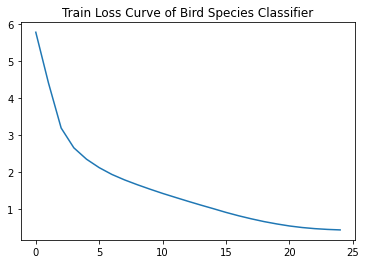

In [17]:
import matplotlib.pyplot as plt

train_losses = torch.tensor(train_losses, device = 'cpu')
plt.plot(np.arange(len(train_losses)), train_losses)
plt.title('Train Loss Curve of Bird Species Classifier')

Text(0.5, 1.0, 'Validation Accuracy Curve of Bird Species Classifier')

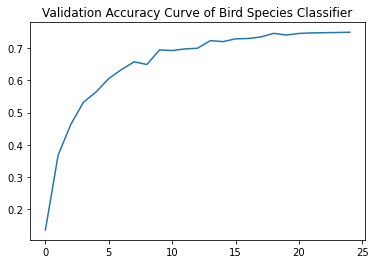

In [18]:
val_losses = torch.tensor(val_losses, device = 'cpu')
plt.plot(np.arange(len(val_losses)), val_losses)
plt.title('Validation Accuracy Curve of Bird Species Classifier')

Text(0.5, 1.0, 'Log-score Curve of Bird Species Classifier')

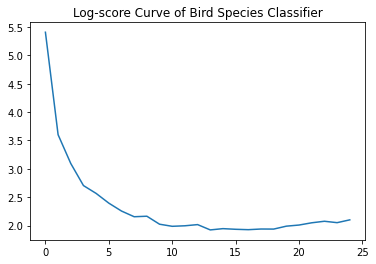

In [19]:
log_scores = torch.tensor(log_scores, device = 'cpu')
plt.plot(np.arange(len(log_scores)), log_scores)
plt.title('Log-score Curve of Bird Species Classifier')

Text(0.5, 1.0, 'F-beta score Curve of Bird Species Classifier')

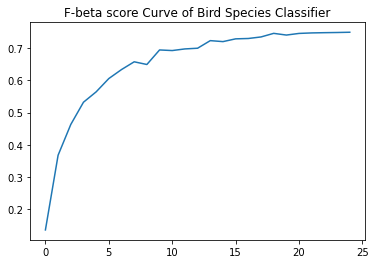

In [20]:
fbeta_scores = torch.tensor(fbeta_scores, device = 'cpu')
plt.plot(np.arange(len(fbeta_scores)), fbeta_scores)
plt.title('F-beta score Curve of Bird Species Classifier')

In [21]:
print('\nAccuracy: %.2f' % (100 * test_scores[0]))
print('Log Loss score:\t%.2f' % (test_scores[1]))
print('Fbeta-score (beta=1.0): \t%.2f' % (test_scores[2]))


Accuracy: 74.50
Log Loss score:	2.12
Fbeta-score (beta=1.0): 	0.74
